# Charm-tagging working points

In [3]:
import os
import ROOT
import getpass
import uproot
import awkward
import matplotlib.pyplot as plt
import pprint
import numpy as np
from tqdm import tqdm,tqdm_notebook
from itertools import permutations
from IPython.display import HTML, display

### Configuration parameters

In [58]:
min_pt = 20
max_abs_eta = 2.5
sample = "Multijet #hat{p_{T}} #in [80,120] GeV"

### Helper functions

In [4]:
def tchain(fpath,tpath,branchlist,steps=None):    
    return uproot.tree.iterate(path=fpath,
                            treepath=tpath,
                            branches=branchlist,
                            entrysteps=steps)

### Grid certificate

In [2]:
password = getpass.getpass("Enter Password for grid certificate: ")
#os.system("voms-proxy-init -S --rfc --voms cms -valid 192:00")
proxy_cmd = "voms-proxy-init --rfc --voms cms -valid 192:00"
os.system('echo %s | %s' % (password, proxy_cmd))

Enter Password········


0

Enter GRID pass phrase for this identity:Contacting lcg-voms2.cern.ch:15002 [/DC=ch/DC=cern/OU=computers/CN=lcg-voms2.cern.ch] "cms"...
Remote VOMS server contacted succesfully.


Created proxy in /afs/cern.ch/user/s/smoortga/.gridproxy.pem.

Your proxy is valid until Wed Oct 14 08:25:28 CEST 2020


In [6]:
nfiles = 20
files_path = ['root://xrootd-cms.infn.it//store/user/smoortga/BTagServiceWork/CTaggerWPs_2017_UltraLegacy/QCD_Pt_80to120_TuneCP5_13TeV_pythia8_RunIISummer19UL17MiniAOD-106X_mc2017_realistic_v6-v2_MINIAODSIM/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/crab_BTagAnalyzer_CTagWP_2017_UltraLegacy/200116_133349/0000/JetTree_mc_%i.root'%idx for idx in range(1,nfiles+1)]
tree_directory = 'btagana/ttree'
branches=["nJet",
          "Jet_pt",
          "Jet_eta",
          'Jet_flavourCleaned',
          'Jet_tightID',
          'Jet_DeepFlavourBDisc',
          'Jet_DeepFlavourCvsLDisc',
          'Jet_DeepFlavourCvsBDisc',
          'Jet_DeepCSVBDisc',
          'Jet_DeepCSVCvsLDisc',
          'Jet_DeepCSVCvsBDisc',
         ]




# n_subtrees = len(list(tchain(files_path,tree_directory,branches) ))
# print "split into %i subtrees."%n_subtrees

In [7]:
trees = tchain(files_path,tree_directory,branches) 
taggers = ['Jet_DeepFlavourBDisc',
           'Jet_DeepFlavourCvsLDisc',
           'Jet_DeepFlavourCvsBDisc',
           'Jet_DeepCSVBDisc',
           'Jet_DeepCSVCvsLDisc',
           'Jet_DeepCSVCvsBDisc',
          ]
flavours = ["b","c","l"]

discriminator_dict = {}
for tagger in taggers:
    discriminator_dict[tagger]={}
    for flav in flavours:
        discriminator_dict[tagger][flav]=[]

        
# for branches in tqdm(trees,
#                     total=n_subtrees,
#                     desc="Progress"):

nevents = 0

for idx,branches in enumerate(trees): 
    print "running tree number %i"%idx
    nevents += len(branches['nJet'])
    #plt.hist(branches['Jet_flavourCleaned'].flatten())
    eta_mask = abs(branches['Jet_eta']) < max_abs_eta
    pt_mask = branches['Jet_pt'] > min_pt
    jetID_mask = branches['Jet_tightID'] == 1
    flavour_mask={}
    for flav in flavours:
        if flav == "b": flavour_mask[flav] = branches['Jet_flavourCleaned'] == 5
        elif flav == "c": flavour_mask[flav] = branches['Jet_flavourCleaned'] == 4
        elif flav == "l": flavour_mask[flav] = (branches['Jet_flavourCleaned'] >= 0) * (branches['Jet_flavourCleaned'] != 4) * (branches['Jet_flavourCleaned'] != 5)
    
    
    
    for tagger in taggers:
        for flav in flavours:
            array_tmp = np.asarray(branches[tagger][eta_mask & pt_mask & jetID_mask & flavour_mask[flav]].flatten())
            discriminator_dict[tagger][flav] = np.concatenate((discriminator_dict[tagger][flav],array_tmp))


#pprint.pprint(discriminator_dict)
print "Processed %i events"%nevents

running tree number 0
running tree number 1
running tree number 2
running tree number 3
running tree number 4
running tree number 5
running tree number 6
running tree number 7
running tree number 8
running tree number 9
running tree number 10
running tree number 11
running tree number 12
running tree number 13
running tree number 14
running tree number 15
running tree number 16
running tree number 17
running tree number 18
running tree number 19
running tree number 20
running tree number 21
running tree number 22
running tree number 23
running tree number 24
running tree number 25
running tree number 26
running tree number 27
running tree number 28
running tree number 29
running tree number 30
running tree number 31
running tree number 32
running tree number 33
Processed 833100 events


### Calculating working points according to some predefined mistags

In [8]:
min_val = 0
max_val = 1
precision = 0.0001


out_dict = {}


def distance(current,target):
    return np.sqrt((current[0]-target[0])**2+(current[1]-target[1])**2)


wp_arr = [
    ["loose",[0.9,0.35]],
    ["medium",[0.25,0.25]],
    ["tight",[0.05,0.25]]
]

for tagger in ["DeepCSV","DeepFlavour"]:
    out_dict[tagger]={}
    for wp,wp_mistag in wp_arr:
        out_dict[tagger][wp]={}
        
        stepsize=0.1
        decay = 0.9
        max_niter = 500
        start_cut = [0.,0.] # CvsL , CvsB
        start_mistag = [1.,1.] # mistag light, mistag b
        
        current_best_cut = start_cut
        current_best_mistag = start_mistag
        niter=0
        curr_tagger = "CvsL"
        while distance(current_best_mistag,wp_mistag) > precision:
            if curr_tagger == "CvsL":
                if current_best_mistag[0]>wp_mistag[0]: current_best_cut=[min(current_best_cut[0]+stepsize,max_val),current_best_cut[1]]
                elif current_best_mistag[0]<wp_mistag[0]:current_best_cut=[max(current_best_cut[0]-stepsize,min_val),current_best_cut[1]]
                curr_tagger = "CvsB"

            elif curr_tagger == "CvsB":
                if current_best_mistag[1]>wp_mistag[1]: current_best_cut=[current_best_cut[0],min(current_best_cut[1]+stepsize,max_val)]
                elif current_best_mistag[0]<wp_mistag[0]: current_best_cut=[current_best_cut[0],max(current_best_cut[1]-stepsize,min_val)]
                curr_tagger = "CvsL"


            tag_mask_light = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['l']>current_best_cut[1])
            all_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])
            tagged_light = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'][tag_mask_light])
            eff_light = float(tagged_light) / float(all_light)

            tag_mask_b = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['b']>current_best_cut[1])
            all_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])
            tagged_b = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'][tag_mask_b])
            eff_b = float(tagged_b) / float(all_b)

            tag_mask_c = (discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']>current_best_cut[0])*(discriminator_dict['Jet_%sCvsBDisc'%tagger]['c']>current_best_cut[1])
            all_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])
            tagged_c = len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'][tag_mask_c])
            eff_c = float(tagged_c) / float(all_c)

            current_best_mistag = [eff_light,eff_b]

            stepsize *=decay


            niter+=1
            if niter>max_niter: break

        print tagger, wp #, eff_c,current_best_mistag,current_best_cut,distance(current_best_mistag,wp_mistag)
        out_dict[tagger][wp]["cut CvsL"] = current_best_cut[0]
        out_dict[tagger][wp]["cut CvsB"] = current_best_cut[1]
        out_dict[tagger][wp]["Eff charm"] = eff_c
        out_dict[tagger][wp]["Eff light"] = current_best_mistag[0]
        out_dict[tagger][wp]["Eff bottom"] = current_best_mistag[1]
        
        
        
        
data = [["Tagger","WP","cut CvsL","cut CvsB","Eff charm","Eff bottom","Eff light"],
        ["DeepCSV","loose","%.3f"%out_dict["DeepCSV"]["loose"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["loose"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["loose"]["Eff light"])],
        ["","medium","%.3f"%out_dict["DeepCSV"]["medium"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["medium"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["medium"]["Eff light"])],
        ["","tight","%.3f"%out_dict["DeepCSV"]["tight"]["cut CvsL"],"%.3f"%out_dict["DeepCSV"]["tight"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepCSV"]["tight"]["Eff light"])],
        ["","","","","","",""],
        ["DeepJet","loose","%.3f"%out_dict["DeepFlavour"]["loose"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["loose"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["loose"]["Eff light"])],
        ["","medium","%.3f"%out_dict["DeepFlavour"]["medium"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["medium"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["medium"]["Eff light"])],
        ["","tight","%.3f"%out_dict["DeepFlavour"]["tight"]["cut CvsL"],"%.3f"%out_dict["DeepFlavour"]["tight"]["cut CvsB"],"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff charm"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff bottom"]),"%.1f%%"%(100*out_dict["DeepFlavour"]["tight"]["Eff light"])],
         
       ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))
       

DeepCSV loose
DeepCSV medium
DeepCSV tight
DeepFlavour loose
DeepFlavour medium
DeepFlavour tight


Tagger,WP,cut CvsL,cut CvsB,Eff charm,Eff bottom,Eff light
DeepCSV,loose,0.000,0.324,90.9%,35.0%,89.8%
,medium,0.157,0.351,53.8%,25.0%,25.0%
,tight,0.347,0.231,35.2%,25.0%,5.0%
,,,,,,
DeepJet,loose,0.033,0.282,92.7%,35.0%,90.0%
,medium,0.095,0.335,56.7%,25.0%,25.0%
,tight,0.203,0.223,40.2%,25.0%,5.0%


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DeepCSV
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_DeepFlavour


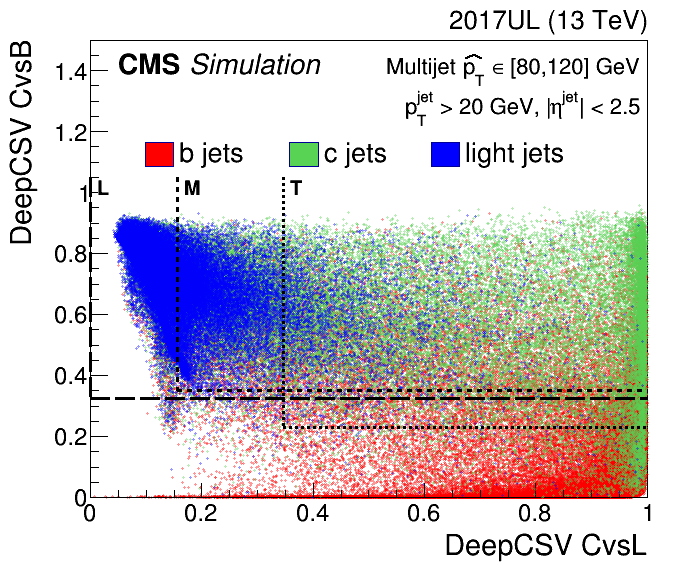

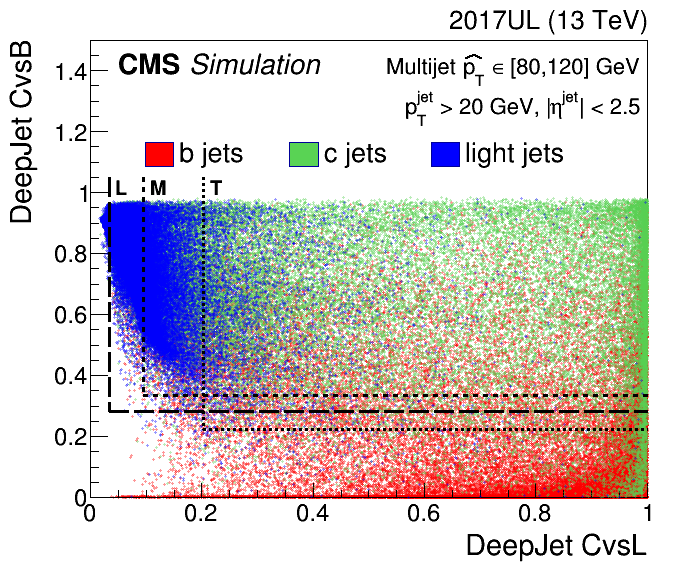

In [80]:
ROOT.gStyle.SetOptStat(0)

canvas_dict = {}
plot_dict = {}
legend_dict = {}
lines_dict = {}


latex_year = ROOT.TLatex()
latex_year.SetTextFont(43)
latex_year.SetTextSize(28)
latex_year.SetTextAlign(32)

latex_cms = ROOT.TLatex()
latex_cms.SetTextFont(43)
latex_cms.SetTextSize(30)
latex_cms.SetTextAlign(11)

latex_topology = ROOT.TLatex()
latex_topology.SetTextFont(43)
latex_topology.SetTextSize(24)
latex_topology.SetTextAlign(31)




for tagger in ["DeepCSV","DeepFlavour"]:

    disc_min = 0
    disc_max = 1
    ncuts = 300
    
    plot_dict[tagger] = {}
    plot_dict[tagger]["Plot_2D_B"] = ROOT.TH2D("Plot_2D_B%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_C"] = ROOT.TH2D("Plot_2D_C%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_DUSG"] = ROOT.TH2D("Plot_2D_DUSG%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    
    #     
#     Plot_2D_B = ROOT.TH2D("Plot_2D_B%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
#     Plot_2D_C = ROOT.TH2D("Plot_2D_C%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
#     Plot_2D_DUSG = ROOT.TH2D("Plot_2D_DUSG%s"%tagger," ;%s CvsL;%s CvsB"%(tagger.replace("Flavour","Jet"),tagger.replace("Flavour","Jet")),ncuts,disc_min,disc_max,ncuts,disc_min,disc_max + (disc_max-disc_min)/2.)
    
    min_n_flav = min(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']),len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']),len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']))
    
    
    plot_dict[tagger]["Plot_2D_B"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
    plot_dict[tagger]["Plot_2D_C"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
    plot_dict[tagger]["Plot_2D_DUSG"].FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    
#     Plot_2D_B.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
#     Plot_2D_C.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
#     Plot_2D_DUSG.FillN(min_n_flav,discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    
    #Plot_2D_B.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['b'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['b'])))
    #Plot_2D_C.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['c'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['c'])))
    #Plot_2D_DUSG.FillN(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l']),discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'],discriminator_dict['Jet_%sCvsBDisc'%tagger]['l'],np.ones(len(discriminator_dict['Jet_%sCvsLDisc'%tagger]['l'])))

    canvas_dict[tagger] = ROOT.TCanvas("c_%s"%tagger,"c_%s"%tagger,700,600)
    canvas_dict[tagger].cd()
    ROOT.gPad.SetMargin(0.13,0.07,0.13,0.07)
    legend_dict[tagger] = ROOT.TLegend(0.2,0.7,0.90,0.76)
    legend_dict[tagger].SetNColumns(3)
    legend_dict[tagger].SetFillColor(0)
    legend_dict[tagger].SetFillStyle(0)
    legend_dict[tagger].SetBorderSize(0)
    
    
    
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetNdivisions(510)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_B"].GetXaxis().SetNdivisions(505)
    plot_dict[tagger]["Plot_2D_B"].GetZaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_C"].GetXaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetXaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_C"].GetZaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetTitleOffset(1.1)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetTitleSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetLabelSize(0.045)
    plot_dict[tagger]["Plot_2D_DUSG"].GetXaxis().SetTitleSize(0.065)
    plot_dict[tagger]["Plot_2D_DUSG"].GetXaxis().SetLabelSize(0.055)
    plot_dict[tagger]["Plot_2D_DUSG"].GetZaxis().SetLabelSize(0.055)

    plot_dict[tagger]["Plot_2D_B"].SetMarkerColorAlpha(ROOT.kRed,0.4)
    plot_dict[tagger]["Plot_2D_B"].SetFillColor(ROOT.kRed)
    plot_dict[tagger]["Plot_2D_B"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_B"],"b jets","f")
    #ROOT.gPad.SetTickx(1)
    #ROOT.gPad.SetTicky(1)
    plot_dict[tagger]["Plot_2D_B"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_B"].Draw()


    plot_dict[tagger]["Plot_2D_C"].SetMarkerColorAlpha(8,0.4)
    plot_dict[tagger]["Plot_2D_C"].SetFillColor(8)
    plot_dict[tagger]["Plot_2D_C"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_C"],"c jets","f")
    plot_dict[tagger]["Plot_2D_C"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_C"].Draw("same")


    plot_dict[tagger]["Plot_2D_DUSG"].SetMarkerColorAlpha(ROOT.kBlue,0.4)
    plot_dict[tagger]["Plot_2D_DUSG"].SetFillColor(ROOT.kBlue)
    plot_dict[tagger]["Plot_2D_DUSG"].SetMarkerStyle(6)
    legend_dict[tagger].AddEntry(plot_dict[tagger]["Plot_2D_DUSG"],"light jets","f")
    plot_dict[tagger]["Plot_2D_DUSG"].GetYaxis().SetRangeUser(disc_min,disc_max + (disc_max-disc_min)/2.)
    plot_dict[tagger]["Plot_2D_DUSG"].Draw("same")

    legend_dict[tagger].Draw("same")\
    
    wp_dict = {"L":[out_dict[tagger]["loose"]["cut CvsL"],out_dict[tagger]["loose"]["cut CvsB"],9,0.18],"M":[out_dict[tagger]["medium"]["cut CvsL"],out_dict[tagger]["medium"]["cut CvsB"],7,0.26],"T":[out_dict[tagger]["tight"]["cut CvsL"],out_dict[tagger]["tight"]["cut CvsB"],2,0.79]} 
    lines_dict[tagger] = {}
    for wp,borders in wp_dict.iteritems():
        lines_dict[tagger][wp+"_h"] = ROOT.TLine()
        lines_dict[tagger][wp+"_h"].SetLineStyle(borders[2])
        lines_dict[tagger][wp+"_h"].SetLineColor(1)
        lines_dict[tagger][wp+"_h"].SetLineWidth(3)
        lines_dict[tagger][wp+"_h"].DrawLine(borders[0],borders[1],1,borders[1])
        lines_dict[tagger][wp+"_v"] = ROOT.TLine()
        lines_dict[tagger][wp+"_v"].SetLineStyle(borders[2])
        lines_dict[tagger][wp+"_v"].SetLineColor(1)
        lines_dict[tagger][wp+"_v"].SetLineWidth(3)
        lines_dict[tagger][wp+"_v"].DrawLine(borders[0],borders[1],borders[0],1.05)
        lines_dict[tagger][wp+"_txt"] = ROOT.TPaveText(borders[0]+0.01,1-0.05,borders[0]+0.05,1.03,"NB")
        lines_dict[tagger][wp+"_txt"].SetTextAlign(11)
        lines_dict[tagger][wp+"_txt"].AddText("#bf{"+wp+"}")
        lines_dict[tagger][wp+"_txt"].SetTextFont(43)
        lines_dict[tagger][wp+"_txt"].SetTextSize(22)
        lines_dict[tagger][wp+"_txt"].SetFillColor(0)
        lines_dict[tagger][wp+"_txt"].SetFillStyle(0)
        lines_dict[tagger][wp+"_txt"].SetBorderSize(0)
        lines_dict[tagger][wp+"_txt"].Draw("same")
    
    latex_year.DrawLatexNDC(0.93,0.96,"2017UL (13 TeV)")
    latex_cms.DrawLatexNDC(0.17,0.87,"#bf{CMS} #it{Simulation}")
    latex_topology.DrawLatexNDC(0.92,0.87,sample)
    latex_topology.DrawLatexNDC(0.92,0.80,"p_{T}^{jet} > %i GeV, |#eta^{jet}| < %.1f"%(min_pt,max_abs_eta))
    
    
    canvas_dict[tagger].Draw()

In [11]:
#os.system('dasgoclient -query="file dataset=/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/RunIISummer19UL18NanoAOD-PUForMUOVal_106X_upgrade2018_realistic_v11_L1v1-v3/NANOAODSIM" > files.txt')
#os.system('dasgoclient -query="file dataset=/TTTo2L2Nu_TuneCP5up_13TeV-powheg-pythia8/RunIISummer19UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v2/NANOAODSIM" > files.txt')


In [10]:
# input_files = open("files.txt","r")
# infile_array = []
# for idx,f_ in enumerate(input_files.readlines()):
#     infile_array.append(f_.replace("\n",""))
    
# input_files.close()
# print "found %i files in 'files.txt'"%(idx+1)
# #print infile_array

found 221 files in 'files.txt'


In [10]:
# f = uproot.open('root://xrootd-cms.infn.it//store/user/smoortga/BTagServiceWork/CTaggerWPs_2017_UltraLegacy/QCD_Pt_80to120_TuneCP5_13TeV_pythia8_RunIISummer19UL17MiniAOD-106X_mc2017_realistic_v6-v2_MINIAODSIM/QCD_Pt_80to120_TuneCP5_13TeV_pythia8/crab_BTagAnalyzer_CTagWP_2017_UltraLegacy/200116_133349/0000/JetTree_mc_1.root')
# t = f['btagana/ttree']
# t.keys()